# Examining the Gordon prescription

In [9]:
# imports

from importlib import reload

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import plotting

In [2]:
%matplotlib ipympl

# Load

In [3]:
ds = loisel23.load_ds(4,0)
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

## Unpack for convenience

In [33]:
wave = ds.Lambda.data
Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data

# $u$

In [34]:
u = bb / (a+bb)
u.shape

(3320, 81)

# $r_{\rm rs}$

In [35]:
A, B = 0.52, 1.17
rrs = Rrs / (A + B*Rrs)

# Wavelengths

In [57]:
i370 = np.argmin(np.abs(wave-370.))
i440 = np.argmin(np.abs(wave-440.))
i500 = np.argmin(np.abs(wave-500.))
i600 = np.argmin(np.abs(wave-600.))

In [37]:
def rrs_func(uval, G1, G2):
    rrs = G1*uval + G2*uval**2
    return rrs

# GIOP

In [24]:
G1, G2 = 0.0949, 0.0794  # Gordon
G1_lee, G2_lee = 0.0949, 0.0794  # Gordon
uval = np.linspace(0., 0.25, 1000)
rrs_GIOP = rrs_func(uval, G1, G2)
Rrs_GIOP = A*rrs_GIOP / (1 - B*rrs_GIOP)

# Fit

In [58]:
save_ans = []
for ii in [i370, i440, i500, i600]:
    ans, cov = curve_fit(rrs_func, u[:,ii], rrs[:,ii], p0=[0.1, 0.1], sigma=np.ones_like(u[:,ii])*0.0003)
    save_ans.append(ans)

In [56]:
save_ans[-1]

array([ 0.1165968 , -1.18249731])

# Plots

In [44]:
rrs[:,i600].min()

0.00047002986

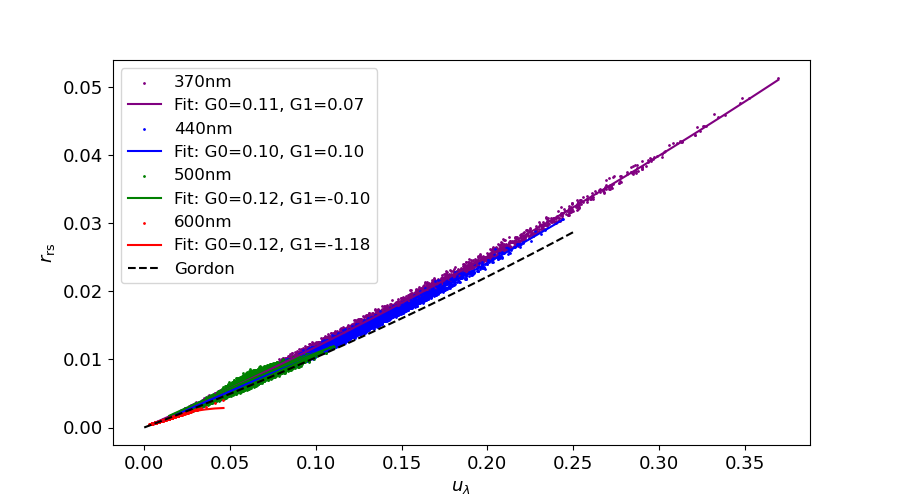

In [59]:
#
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
for lbl, clr, idx, ans in zip(['370nm', '440nm', '500nm', '600nm'],
                              ['purple', 'b','g', 'r'],
                              [i370, i440, i500, i600],
                              save_ans):
    ax.scatter(u[:,idx], rrs[:,idx], color=clr, s=1., label=lbl)
    irrs = rrs_func(u[:,idx], ans[0], ans[1])
    usrt = np.argsort(u[:,idx])
    ax.plot(u[usrt,idx], irrs[usrt], '-', color=clr, label=f'Fit: G0={ans[0]:0.2f}, G1={ans[1]:0.2f}')
# GIOP
ax.plot(uval, rrs_GIOP, 'k--', label='Gordon')
#
ax.set_xlabel(r'$u_\lambda$')
ax.set_ylabel(r'$r_{\rm rs}$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()